In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
import time
import os
from matplotlib.colors import ListedColormap
from einops import rearrange
from oracle.models.transformer_encoder import VisionTransformer
from oracle.models.transformer_decoder import SegmentationTransformer
from oracle.models.transformer_segmenter import MultiResSegmenter
from oracle.image_utils import convert_1d_index_to_2d, convert_scale_to_coords_in_full_res, convert_1d_patched_index_to_2d_org_index


/home/david/anaconda3/envs/MedicalSemSeg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
train_folder = '/media/david/T7/Kvasir-SEG/train'
val_folder = '/media/david/T7/Kvasir-SEG/validation'
test_folder = '/media/david/T7/Kvasir-SEG/test'

In [4]:
def kvasir_data_to_dict(folder):
    images = os.listdir(os.path.join(folder, 'images'))
    data_list_dict = []
    for i in images:
        try:     
            if os.path.exists(os.path.join(folder, 'masks', i)):
                data_dict = {'image': os.path.join(folder, 'images', i),
                             'label': os.path.join(folder, 'masks', i)}
                data_list_dict.append(data_dict)
        except Exception as e:
            print("Failed to find label file {} with exception {}".format(i, e))
    
    return data_list_dict
    

In [5]:
train_data = kvasir_data_to_dict(train_folder)
val_data = kvasir_data_to_dict(val_folder)
test_data = kvasir_data_to_dict(test_folder)



In [6]:
transform_list = [monai.transforms.LoadImaged(keys=['image', 'label']),
              monai.transforms.EnsureChannelFirstD(keys=['image', "label"]),
              monai.transforms.NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
              monai.transforms.ToTensord(keys=["image", "label"])]
transforms = monai.transforms.Compose(transform_list)

train_dataset = monai.data.Dataset(train_data, transform=transforms)
val_dataset = monai.data.Dataset(val_data, transform=transforms)

In [7]:
data_loader_val = monai.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=False
    )

data_loader_train = monai.data.DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
    persistent_workers=False
    )

In [8]:
out = data_loader_train.dataset.__getitem__(7)
example_inputs = out['image']
example_labels = out['label']
print(example_inputs.shape)

(3, 352, 352)


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def visualize_data(im, lab):
    plt.figure()
    if im is not None:
        if im.shape[0] < 4:
            im = im.permute(1, 2, 0)
        plt.imshow(im.squeeze().cpu().numpy())
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    else:
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none')

In [11]:
def visualize_patches_scale(patches_scale_coords, n_scales, initial_patch_size, image_size, org_image=None, labels=None):
    colormap = ListedColormap(['silver', 'chocolate', 'blue', 'green', 'orange', 'magenta', 'red', 'lime'])
    full_image = torch.zeros(image_size[0] * image_size[1])
    for scale in range(n_scales):
        patch_size = initial_patch_size // 2**scale
        indx_curr_scale = patches_scale_coords[:, 0] == scale
        coords_at_curr_scale = patches_scale_coords[indx_curr_scale, 1]
        coords_at_org_scale = convert_scale_to_coords_in_full_res(coords_at_curr_scale, patch_size, image_size[0])
        full_image[coords_at_org_scale] = scale
    full_image = full_image.view(image_size[0], image_size[1])
    if org_image is not None:
        plt.imshow(org_image.squeeze().cpu().numpy(), cmap='gray')
    if labels is not None:
        plt.imshow(labels.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    plt.imshow(full_image.squeeze().cpu().numpy(), interpolation='none', alpha=0.9, cmap=colormap)


2024-11-20 16:23:23,315 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


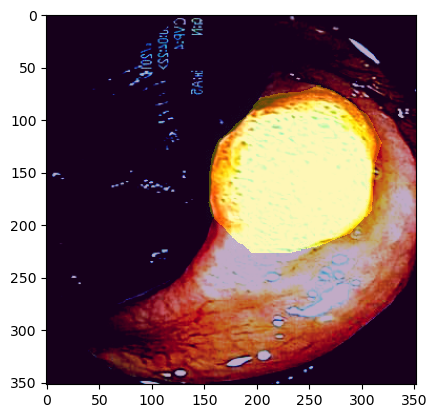

In [12]:
visualize_data(example_inputs, example_labels)

In [13]:
def create_oracle_labels(labels, patch_size): 
    max = F.max_pool2d(labels.float(), patch_size, stride=patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), patch_size, stride=patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

(4, 4)
(8, 8)
(16, 16)
(32, 32)


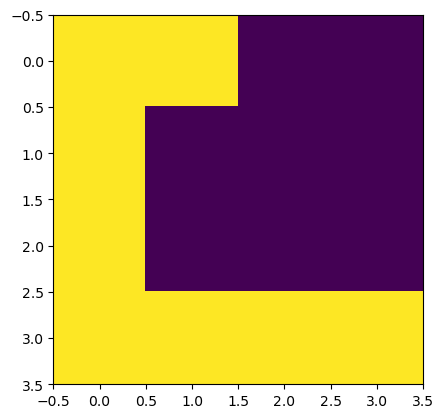

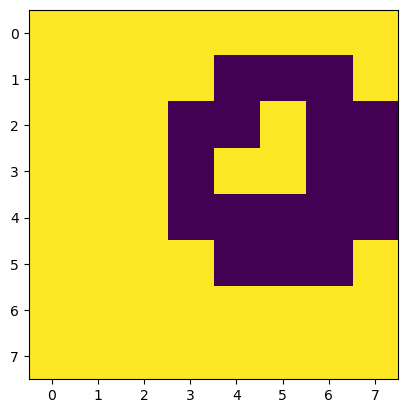

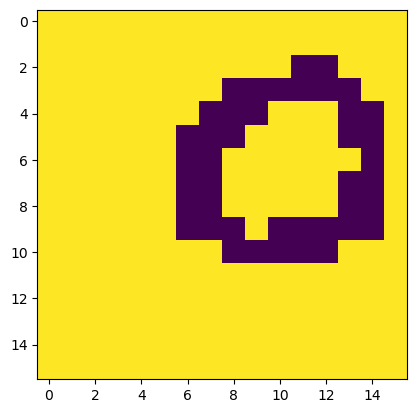

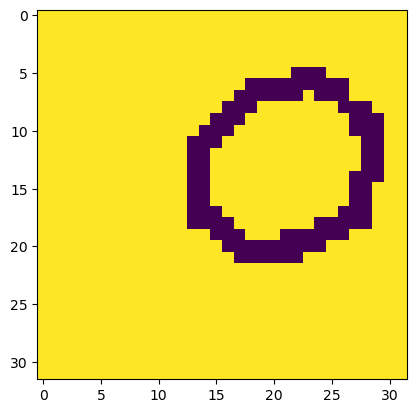

In [14]:
patch_sizes_used = [88, 44, 22, 11]
oracle_labels_multires = []
for ps in patch_sizes_used:
    ol = create_oracle_labels(example_labels, ps)
    oracle_labels_multires.append(ol)
    visualize_data(None, ol)
    print(ol.shape)
    #print(ol.sum())


#oracle_labels = create_oracle_labels(labels, 64)
#visualize_data(inputs, oracle_labels)

In [15]:
d_encoder = 64
n_encoder_layers = 4
patch_size = 88
image_size = (example_inputs.shape[1], example_inputs.shape[2])

model = MultiResSegmenter(image_size=image_size,
                          patch_size=patch_size,
                          channels=3,
                          n_layers_encoder=n_encoder_layers,
                          d_encoder=d_encoder,
                          d_ff_encoder=d_encoder*4,
                          n_heads_encoder=4,
                          n_layers_decoder=2,
                          d_decoder=64,
                          d_ff_decoder=256,
                          n_heads_decoder=4,
                          n_scales=4,
                          n_cls=2)

model = model.to(device)
print(model)
print("Total parameters: {}".format(count_parameters(model)))
print("Encoder parameters: {}".format(count_parameters(model.encoder)))
print("Decoder parameters: {}".format(count_parameters(model.decoder)))

MultiResSegmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 64, kernel_size=(88, 88), stride=(88, 88))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (rel_pos_embs): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x4x64 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x4x64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x4x64 (GPU 0)]
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): FeedForward(
          (fc

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=2)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=2)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

with torch.no_grad():
    _, enc_out, _ = model(example_inputs.unsqueeze(0).to(device), oracle_labels_multires)
    print("Number of tokens after encoder: {}".format(enc_out.shape[1]))


for e in range(epochs):
    for batch in data_loader_train:
        epoch_start = time.time()
        inputs, labels = (batch["image"], batch["label"])
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        oracle_labels_multires = []
        for ps in patch_sizes_used:
            ol = create_oracle_labels(labels, ps)
            oracle_labels_multires.append(ol.squeeze().cpu())
            print(ol.squeeze().shape)
        outputs, _, patches_scale_coords = model(inputs, oracle_labels_multires)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        labels_convert = [post_label(labels[0])]
        output_convert = [post_pred(outputs[0])]
        dice_metric(y_pred=output_convert, y=labels_convert)
        dice_scores, dice_not_nans = dice_metric.aggregate()
        epoch_time = time.time() - epoch_start
        if ((e + 1) % print_every_n_epochs) == 0:
            print("Epoch: {}, Dice score: {:.4f}, loss: {:.4f}, lr: {:.4f}, epoch_time: {:.4f}".format(e, dice_scores.item(), loss.item(), scheduler.get_last_lr()[0], epoch_time))
            pred = torch.argmax(outputs, dim=1)
            visualize_data(inputs, pred)
    scheduler.step()


torch.Size([16, 2])
torch.int64
torch.Size([16])
torch.int64
tensor(15, device='cuda:0')
(16,)
torch.int64
tensor(0)
tensor(1)


TypeError: only integer tensors of a single element can be converted to an index

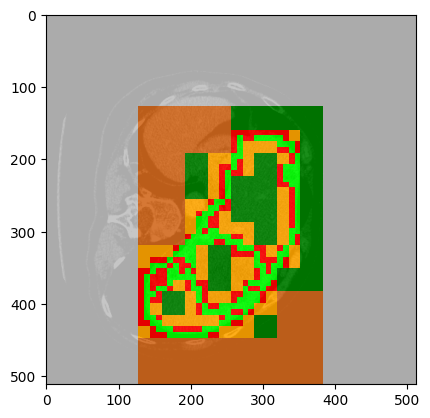

In [ ]:
visualize_patches_scale(patches_scale_coords, n_encoder_layers, patch_size, image_size, inputs)